In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds

from PIL import Image, ImageOps
import random
from sklearn.metrics import matthews_corrcoef
import tensorflow.keras.backend as K
from sklearn.metrics import roc_curve, auc

In [2]:
ds = tfds.load("imagenette/160px-v2", split=['train', 'validation'])
df_train = tfds.as_dataframe(ds[0])
df_test  = tfds.as_dataframe(ds[1])
df_train.shape, df_test.shape
train_labels = df_train['label'].to_numpy(dtype=np.float32)
test_labels = df_test['label'].to_numpy(dtype=np.float32)
train_labels.shape, test_labels.shape
# Создание массивов для изображений с уменьшенным размером
image_height, image_width = 100, 100  # уменьшаем размер изображений
train_images = np.zeros(shape=(df_train.shape[0], image_height, image_width, 3), dtype=np.float32)
test_images  = np.zeros(shape=(df_test.shape[0], image_height, image_width, 3), dtype=np.float32)
# Изменение размера изображений и сохранение в массивы
for idx in range(train_labels.shape[0]):
    img = Image.fromarray(df_train.iloc[idx]['image'])
    img_resized = img.resize((image_width, image_height))
    train_images[idx, :, :, :] = np.array(img_resized)

for idx in range(test_labels.shape[0]):
    img = Image.fromarray(df_test.iloc[idx]['image'])
    img_resized = img.resize((image_width, image_height))
    test_images[idx, :, :, :] = np.array(img_resized)
train_images /= 255
test_images  /= 255

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/9469 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imagenette/160px-v2/1.0.0.incompleteIZ2EOM/imagenette-train.tfrecord*...: …

Generating validation examples...:   0%|          | 0/3925 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imagenette/160px-v2/1.0.0.incompleteIZ2EOM/imagenette-validation.tfrecord*…

Dataset imagenette downloaded and prepared to /root/tensorflow_datasets/imagenette/160px-v2/1.0.0. Subsequent calls will reuse this data.


7. Оставьте в наборе изображения трех классов, указанных в индивидуальном задании. Обучите нейронные сети MLP и CNN задаче многоклассовой классификации изображений (требования к архитектуре сетей указаны в индивидуальном задании).
Показатель качества многоклассовой классификации:

средняя точность классов, где точность (precision) класса равна доле правильных предсказаний для всех точек, относимых классификатором к этому классу.

In [3]:
# Фильтрация данных для классов 1, 2 и 3
train_indices = np.isin(train_labels, [1, 2, 3])
test_indices = np.isin(test_labels, [1, 2, 3])

train_images_multiclass = train_images[train_indices]
test_images_multiclass = test_images[test_indices]
train_labels_multiclass = train_labels[train_indices]
test_labels_multiclass = test_labels[test_indices]

# Преобразование меток в формат 0, 1, 2 для классов 1, 2, 3
label_mapping = {1: 0, 2: 1, 3: 2}
train_labels_multiclass = np.array([label_mapping[label] for label in train_labels_multiclass])
test_labels_multiclass = np.array([label_mapping[label] for label in test_labels_multiclass])


# Нейронная сеть MLP

In [4]:
tf.random.set_seed(42)

model_mlp = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(image_height, image_width, 3)),
    tf.keras.layers.Dense(100, activation='leaky_relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(80, activation='leaky_relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(60, activation='leaky_relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(40, activation='leaky_relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(3, activation='softmax')
])
model_mlp.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.AdamW(),
    metrics=['accuracy']
)

history_mlp = model_mlp.fit(
    train_images_multiclass,
    train_labels_multiclass,
    epochs=25,
    batch_size=32,
    validation_data=(test_images_multiclass, test_labels_multiclass))


Epoch 1/25
88/88 [==============================] - 11s 90ms/step - loss: 3.0467 - accuracy: 0.3528 - val_loss: 1.0763 - val_accuracy: 0.3972
Epoch 2/25
88/88 [==============================] - 7s 75ms/step - loss: 1.4381 - accuracy: 0.3760 - val_loss: 1.0366 - val_accuracy: 0.4613
Epoch 3/25
88/88 [==============================] - 6s 73ms/step - loss: 1.2581 - accuracy: 0.4013 - val_loss: 1.0197 - val_accuracy: 0.4798
Epoch 4/25
88/88 [==============================] - 7s 82ms/step - loss: 1.1799 - accuracy: 0.4145 - val_loss: 1.0221 - val_accuracy: 0.4675
Epoch 5/25
88/88 [==============================] - 4s 48ms/step - loss: 1.1540 - accuracy: 0.4376 - val_loss: 0.9900 - val_accuracy: 0.4815
Epoch 6/25
88/88 [==============================] - 5s 56ms/step - loss: 1.1076 - accuracy: 0.4391 - val_loss: 1.0360 - val_accuracy: 0.4807
Epoch 7/25
88/88 [==============================] - 5s 56ms/step - loss: 1.0802 - accuracy: 0.4401 - val_loss: 1.0047 - val_accuracy: 0.4877
Epoch 8/25
8

In [6]:
# Оценка результатов обучения
loss_reduction = (history_mlp.history['loss'][0] - history_mlp.history['loss'][-1]) / history_mlp.history['loss'][0] * 100
print(f"Потери снизились на {loss_reduction:.2f}%.")

# Оценка результатов обучения
train_loss = history_mlp.history['loss']
val_loss = history_mlp.history['val_loss']

if val_loss[-1] < train_loss[-1]:
    print("Модель недообучилась.")
elif val_loss[-1] > train_loss[-1] and (val_loss[-1] - train_loss[-1]) / val_loss[-1] > 0.1:
    print("Модель переобучилась")
else:
    print("Модель нормально обучилась.")

Потери снизились на 69.02%.
Модель нормально обучилась.


# Нейронная сеть CNN

In [7]:
tf.random.set_seed(42)

# Задание размеров входных изображений
image_height, image_width = 160, 160

# Изменение размера изображений
train_images_resized = tf.image.resize(train_images_multiclass, [image_height, image_width])
test_images_resized = tf.image.resize(test_images_multiclass, [image_height, image_width])

model_cnn = tf.keras.Sequential([
    tf.keras.layers.Conv2D(8, (5, 5), activation='relu', input_shape=(image_height, image_width, 3)),
    tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(8, (5, 5), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(8, (5, 5), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(8, (5, 5), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(8, (5, 5), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='tanh'),
    tf.keras.layers.Dense(3, activation='softmax')
])


In [8]:
model_cnn.compile(
    optimizer=tf.keras.optimizers.Adafactor(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_cnn = model_cnn.fit(
    train_images_resized, train_labels_multiclass,
    epochs=15,
    batch_size=32,
    validation_data=(test_images_resized, test_labels_multiclass)
)


Epoch 1/15
88/88 [==============================] - 67s 730ms/step - loss: 1.1133 - accuracy: 0.3115 - val_loss: 1.0984 - val_accuracy: 0.3445
Epoch 2/15
88/88 [==============================] - 60s 685ms/step - loss: 1.0979 - accuracy: 0.3628 - val_loss: 1.0976 - val_accuracy: 0.4209
Epoch 3/15
88/88 [==============================] - 58s 664ms/step - loss: 1.0935 - accuracy: 0.3860 - val_loss: 1.0961 - val_accuracy: 0.4701
Epoch 4/15
88/88 [==============================] - 59s 669ms/step - loss: 1.0934 - accuracy: 0.3770 - val_loss: 1.0940 - val_accuracy: 0.4411
Epoch 5/15
88/88 [==============================] - 60s 675ms/step - loss: 1.0901 - accuracy: 0.3881 - val_loss: 1.0912 - val_accuracy: 0.4508
Epoch 6/15
88/88 [==============================] - 65s 743ms/step - loss: 1.0820 - accuracy: 0.4084 - val_loss: 1.0836 - val_accuracy: 0.4350
Epoch 7/15
88/88 [==============================] - 64s 729ms/step - loss: 1.0666 - accuracy: 0.4369 - val_loss: 1.0696 - val_accuracy: 0.4657

Оно выполнялось более 15 минут...

In [13]:
# Оценка результатов обучения
loss_reduction = (history_mlp.history['loss'][0] - history_mlp.history['loss'][-1]) / history_mlp.history['loss'][0] * 100
print(f"Потери снизились на {loss_reduction:.2f}%.")

# Оценка результатов обучения
train_loss = history_mlp.history['loss']
val_loss = history_mlp.history['val_loss']

if val_loss[-1] < train_loss[-1]:
    print("Модель недообучилась.")
elif val_loss[-1] > train_loss[-1] and (val_loss[-1] - train_loss[-1]) / val_loss[-1] > 0.1:
    print("Модель переобучилась")
else:
    print("Модель нормально обучилась.")

Потери снизились на 69.02%.
Модель недообучилась.


8. Сравните качество многоклассовой классификации нейронными сетями при помощи показателя качества, указанного в индивидуальном задании.

In [17]:
from sklearn.metrics import classification_report, precision_score

y_pred_mlp = model_mlp.predict(test_images)
y_pred_cnn = model_cnn.predict(test_images_resized)

# Преобразование предсказаний в метки классов
y_pred_mlp_classes = np.argmax(y_pred_mlp, axis=1)
y_pred_cnn_classes = np.argmax(y_pred_cnn, axis=1)

# Вычисление средней точности для MLP
precision_mlp = precision_score(test_labels_multiclass, y_pred_mlp_classes, average='macro')
print("Средняя точность для MLP: {:.4f}".format(precision_mlp))

# Вычисление средней точности для CNN
precision_cnn = precision_score(test_labels_multiclass, y_pred_cnn_classes, average='macro')
print("Средняя точность для CNN: {:.4f}".format(precision_cnn))


36/36 [==============================] - 6s 148ms/step


ValueError: Found input variables with inconsistent numbers of samples: [1138, 3925]

In [21]:
from sklearn.metrics import precision_score

# Обработка данных для трех классов (1, 2, 3)
train_indices = np.isin(train_labels, [1, 2, 3])
test_indices = np.isin(test_labels, [1, 2, 3])

train_images_multiclass = train_images[train_indices]
test_images_multiclass = test_images[test_indices]
train_labels_multiclass = train_labels[train_indices]
test_labels_multiclass = test_labels[test_indices]

# Размеры изображений для CNN
image_height, image_width = 160, 160

# Изменение размера изображений для CNN
train_images_resized = tf.image.resize(train_images_multiclass, [image_height, image_width])
test_images_resized = tf.image.resize(test_images_multiclass, [image_height, image_width])


# Прогнозы для тестового набора данных
y_pred_mlp = model_mlp.predict(test_images_multiclass)
y_pred_cnn = model_cnn.predict(test_images_resized)

# Преобразование предсказаний в метки классов
y_pred_mlp_classes = np.argmax(y_pred_mlp, axis=1)
y_pred_cnn_classes = np.argmax(y_pred_cnn, axis=1)

# Вычисление средней точности для MLP
precision_mlp = precision_score(test_labels_multiclass, y_pred_mlp_classes, average='macro')
print("Средняя точность для MLP: {:.4f}".format(precision_mlp))

# Вычисление средней точности для CNN
precision_cnn = precision_score(test_labels_multiclass, y_pred_cnn_classes, average='macro')
print("Средняя точность для CNN: {:.4f}".format(precision_cnn))

36/36 [==============================] - 7s 188ms/step
Средняя точность для MLP: 0.1116
Средняя точность для CNN: 0.1483


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


9. Постройте кривые обучения нейронных сетей многоклассовой классификации для показателей ошибки и доли верных ответов в зависимости от эпохи обучения, подписывая оси и рисунок и создавая легенду.

In [20]:
def learn_graphic(history, metric='accuracy'):
    plt.figure(figsize=(12, 5))

    # Получение значений метрики для обучающей и проверочной выборок
    train_metric = history.history[metric]
    val_metric = history.history[f'val_{metric}']

    # Построение кривых обучения
    epochs = range(1, len(train_metric) + 1)
    plt.plot(epochs, train_metric, 'b', label=f'Training {metric}')
    plt.plot(epochs, val_metric, 'r', label=f'Validation {metric}')
    if history == history_mlp:
        plt.title(f'MLP: {metric} per Epoch')
    else:
        plt.title(f'CNN: {metric} per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.show()


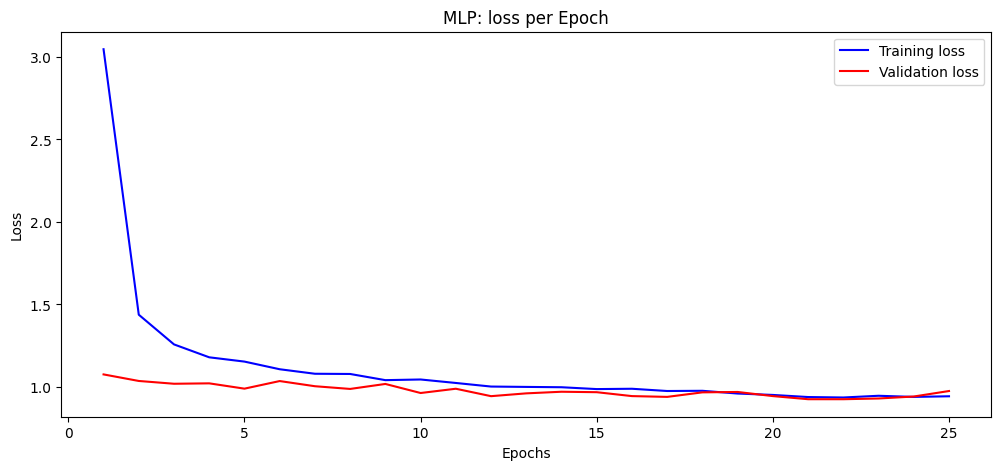

In [22]:
learn_graphic(history_mlp, metric='loss')

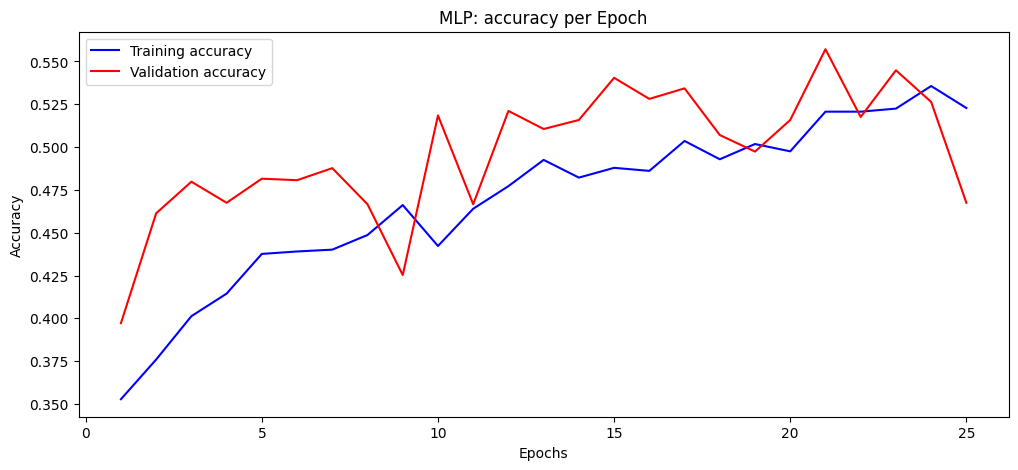

In [23]:
learn_graphic(history_mlp, metric='accuracy')

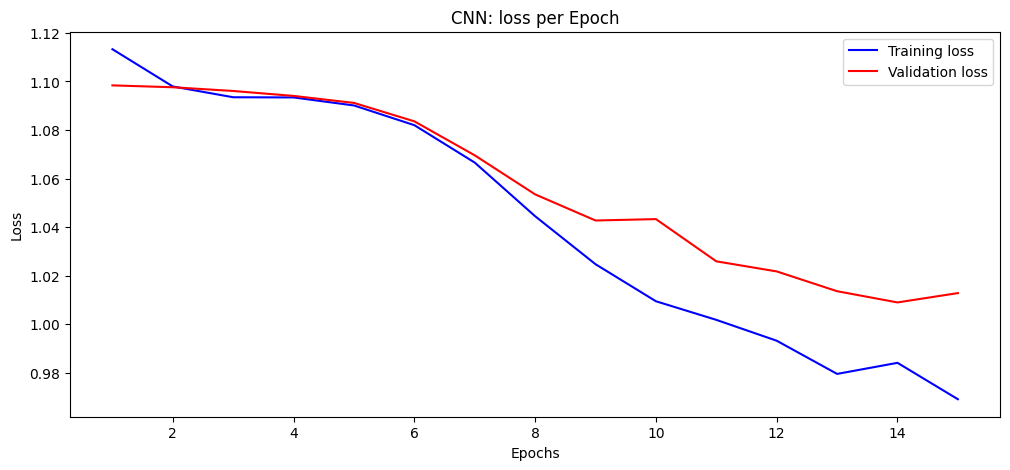

In [24]:
learn_graphic(history_cnn, metric='loss')

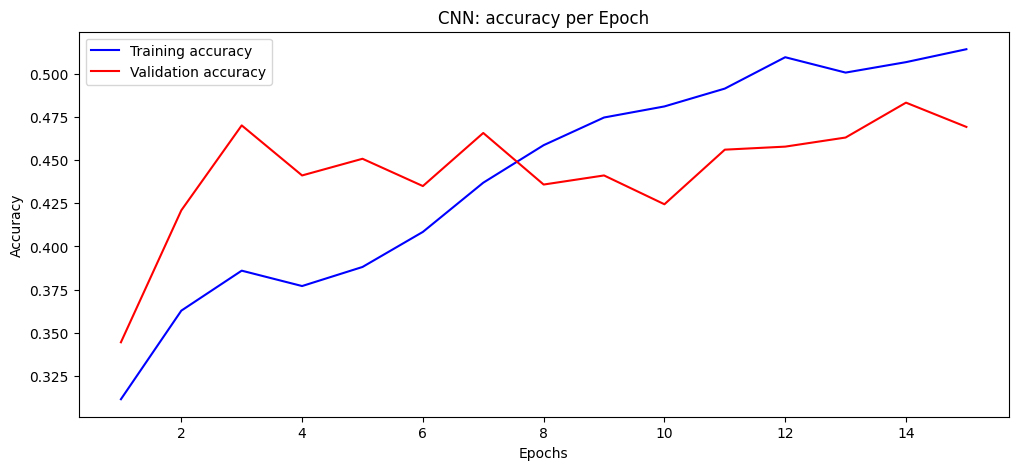

In [25]:
learn_graphic(history_cnn, metric='accuracy')